
 
 ## implementation outlines
 
 ### data visualization
- heatmap
- barplot
- distplot
- probplot
- regplot
- pairplot
 
###  feature engineering
- feature crossing
- one-hot encoding
- binning
- categorizing
- log transformation
- outliers removal
- manipuluate both categoized and numerical data
- dealing with null value


### modeling
- linear regression

### training strategies
- train, test and validation set


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import norm
from scipy.stats import binned_statistic
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Feature Selection
- we'll first have a glance at our data
- we'll pick several features with positive correlation with our target, and do some feature engineering if needed

In [2]:
train_csv = pd.read_csv('/Users/cemilkoc/Downloads/House-Prices-Advanced-Regression-Techniques-master/train.csv')
final_csv = pd.read_csv('/Users/cemilkoc/Downloads/House-Prices-Advanced-Regression-Techniques-master/test.csv')


In [3]:
# first we wanna describe the target columns to make sure we're dealing with regression problem (predict value)
# and we'll look into more detail when we have to do feature engineering
train_csv['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [4]:
print("How many feature candidates do we have? %d" % (len(train_csv.columns) - 1))

How many feature candidates do we have? 80


we'll first narrow down the number of features with 2 criteria:
1. not too many null values
2. positive correlation with our target, SalcePrice

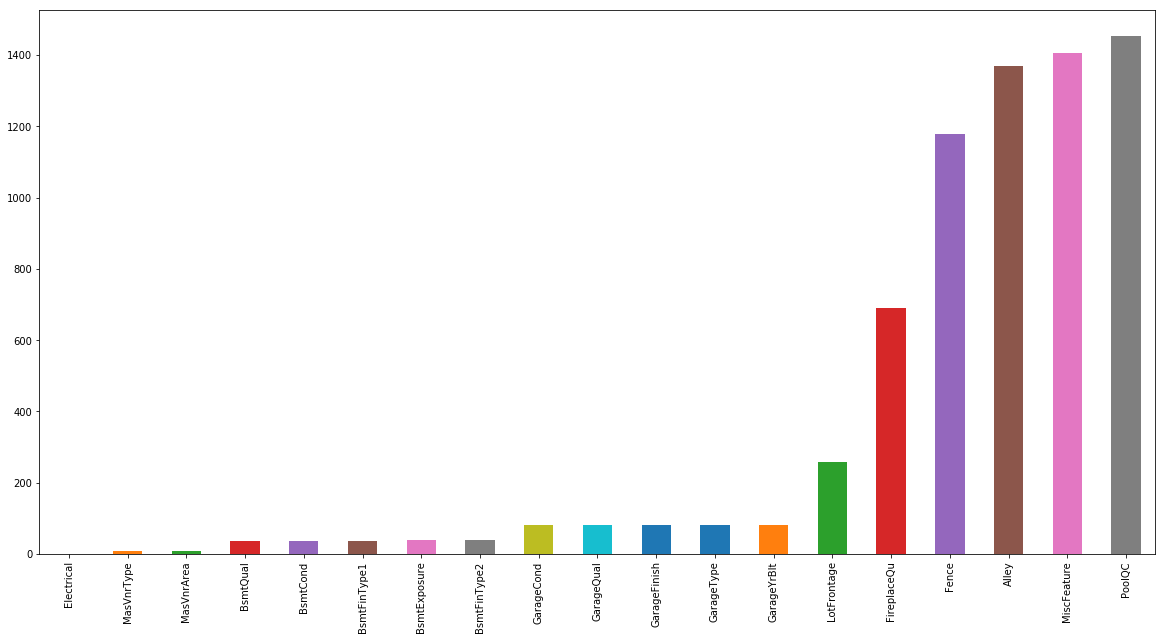

In [6]:
# first we'll visualize null count
null_in_train_csv = train_csv.isnull().sum()
null_in_train_csv = null_in_train_csv[null_in_train_csv > 0]
null_in_train_csv.sort_values(inplace=True)
plt.figure(figsize=(20,10))
null_in_train_csv.plot.bar()

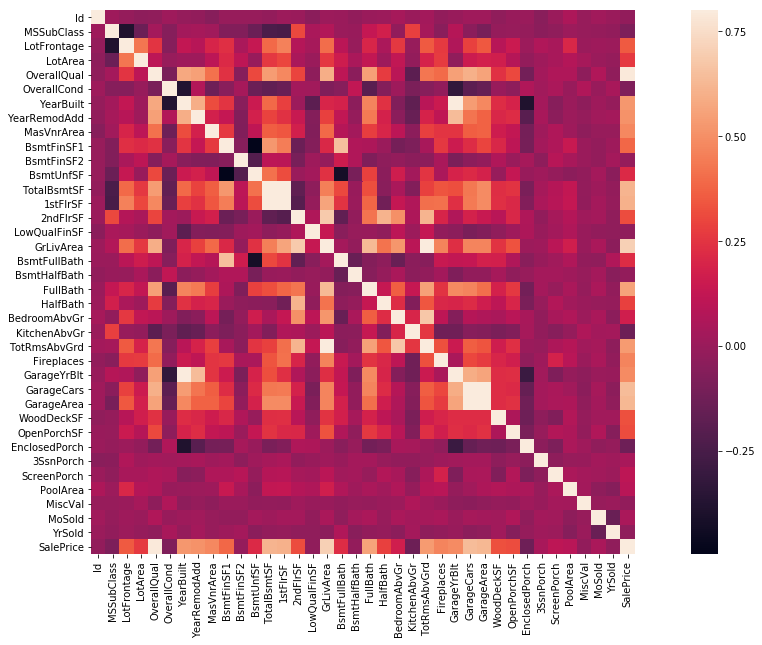

In [8]:
# visualize correlation map
plt.figure(figsize=(20,10))
sns.heatmap(train_csv.corr(), vmax=.8, square=True);

In [9]:
arr_train_cor = train_csv.corr()['SalePrice']
idx_train_cor_gt0 = arr_train_cor[arr_train_cor > 0].sort_values(ascending=False).index.tolist()
print("How many feature candidates have positive correlation with SalePrice(including itself)? %d" % len(idx_train_cor_gt0))

How many feature candidates have positive correlation with SalePrice(including itself)? 28


In [10]:
# we shall list them all, and pick up those we're interested
arr_train_cor[idx_train_cor_gt0]

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
LotArea         0.263843
BsmtFullBath    0.227122
BsmtUnfSF       0.214479
BedroomAbvGr    0.168213
ScreenPorch     0.111447
PoolArea        0.092404
MoSold          0.046432
3SsnPorch       0.044584
Name: SalePrice, dtype: float64

I'll only pick a few to further demonstrate feature engineering techniques, at most 10 candidates. 
After look it up in the [data description](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data), here's how I pick
- *OverallQual* for sure, since its high correlation, and the delegate of categorized data [1-10]
- *GrLivArea*, also because its high correlation and delegate of numerical data
- I'll pick *GarageCars* rather than *GarageArea*, it's somehow like binned
- I've noticed that there are *TotalBsmtSF*, *1stFlrSF*, and *2ndFlrSF*, they seem like related to *GrLivArea*, they're all about the area in the house, I'll do the feature cross techniques with it
- I'll pick *MasVnrArea* although there're a few(8) null values in it, we can fill with mean or something else reasonable
- I'll pick *Fireplaces* for another categorized example, since it sounds like a luxuriness indicator

Here're why I don't pick
- I'll drop *TotRmsAbvGrd* since it looks like highly related to *GrLivArea*, same applies on *GarageCars* and *GarageArea* cases
- I'd rather not pick those time series related for simplicity

So, we have 8 feature candidates now.

In [11]:
idx_meta = ['SalePrice','GrLivArea', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'OverallQual', 'Fireplaces', 'GarageCars']
train_meta = train_csv[idx_meta].copy()
train_meta.head(n=5)

,SalePrice,GrLivArea,MasVnrArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,OverallQual,Fireplaces,GarageCars
0,208500,1710,196.0,856,856,854,7,0,2
1,181500,1262,0.0,1262,1262,0,6,1,2
2,223500,1786,162.0,920,920,866,7,1,2
3,140000,1717,0.0,756,961,756,7,1,3
4,250000,2198,350.0,1145,1145,1053,8,1,3


## Feature Engineering

In [12]:
null_in_masvnrarea = train_meta[train_meta['MasVnrArea'].isnull()].index.tolist()
zero_in_masvnrarea = train_meta['MasVnrArea'][train_meta['MasVnrArea'] == 0].index.tolist()
print("How many null value in MasVnrArea? %d / 1460" % len(null_in_masvnrarea))
print("How many zero value in MasVnrArea? %d / 1460" % len(zero_in_masvnrarea))

How many null value in MasVnrArea? 8 / 1460
How many zero value in MasVnrArea? 861 / 1460


In [13]:
# we'll fill in the null value with 0 from the analysis above
train_meta['MasVnrArea'][null_in_masvnrarea] = 0
print("How many null value in MasVnrArea after filling in null value? %d / 1460" % train_meta['MasVnrArea'].isnull().sum())

How many null value in MasVnrArea after filling in null value? 0 / 1460


<Figure size 720x720 with 0 Axes>

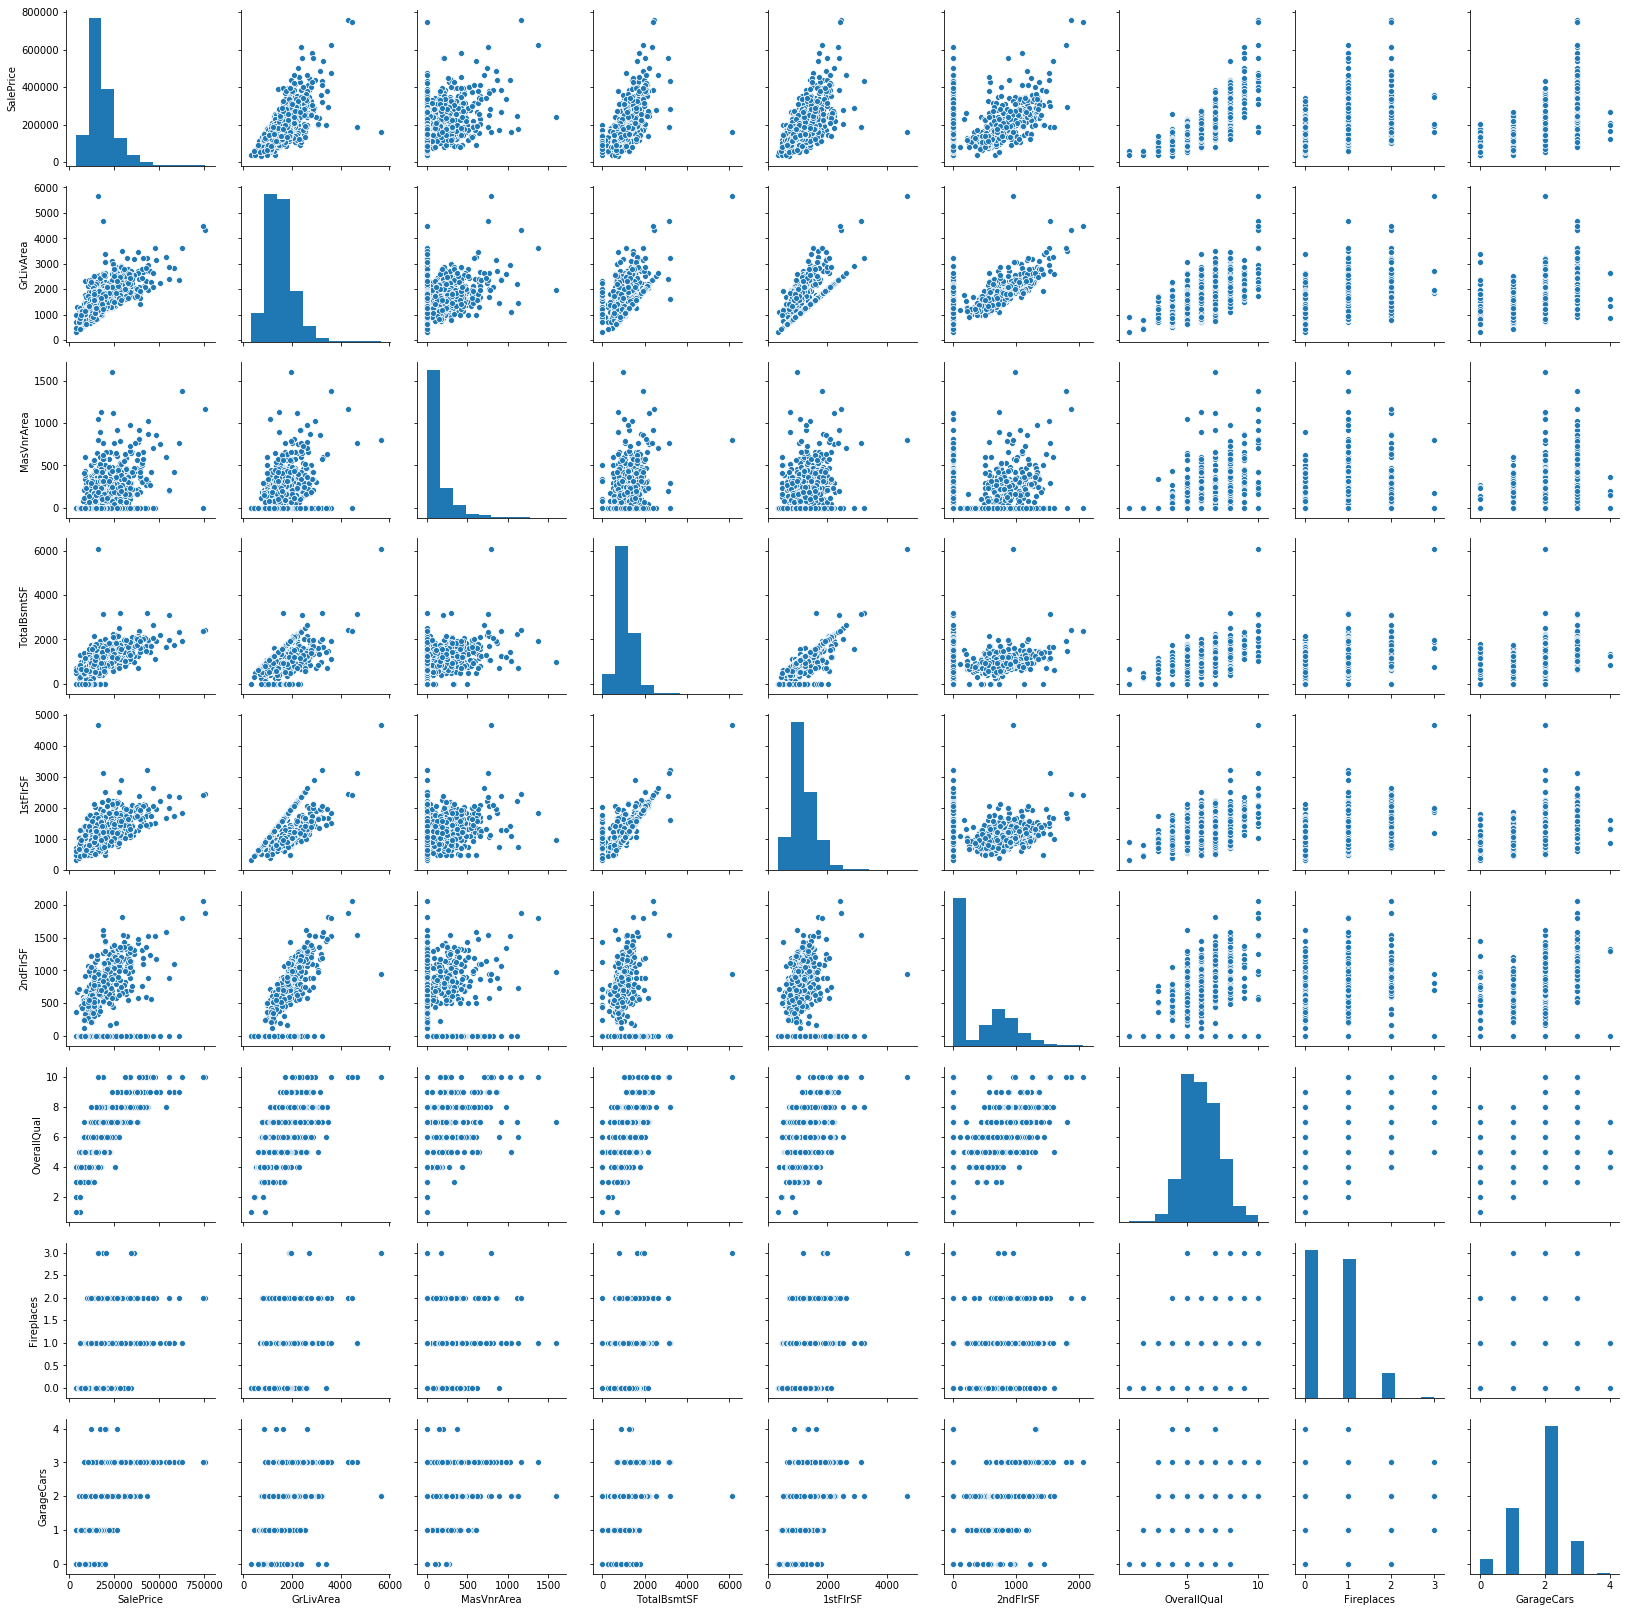

In [15]:
# overview
plt.figure(figsize=(10,10))
sns.pairplot(train_meta)

we can observe something in the pairplot
- there're a few outliers
- we may need to use binning to deal with those zero values in the numerical data
- *GrLivArea* and *1stFlrSF* relation to *SalePrice* look alike, and that's reasonable
- we may use log transformation to *SalePrice* and *GrLivArea*, however, it can't be applied to those numerical data with lots of zero

### Outlier Removal

In [16]:
# GrLivArea
train_meta[(train_meta['GrLivArea'] > 4000) & (train_meta['SalePrice'] < 200000)].index.tolist()

[523, 1298]

In [17]:
# TotalBsmtSF
train_meta[(train_meta['TotalBsmtSF'] > 4000) & (train_meta['SalePrice'] < 200000)].index.tolist()

[1298]

In [18]:
train_meta[(train_meta['1stFlrSF'] > 4000) & (train_meta['SalePrice'] < 200000)].index.tolist()

[1298]

In [19]:
# Thus, we'll remove [523, 1298]
train_clean = train_meta.drop([523,1298])

### Categorize

In [20]:
nonzero_in_masvnrarea = train_clean['MasVnrArea'][train_clean['MasVnrArea'] != 0].index.tolist()
print("How many non-zero value in MasVnrArea now? %d / 1458" % len(nonzero_in_masvnrarea))

How many non-zero value in MasVnrArea now? 589 / 1458


In [21]:
# I'll categorize into zero and non-zero
train_clean['has_MasVnrArea'] = 0
train_clean['has_MasVnrArea'][nonzero_in_masvnrarea] = 1

### Binning and feature cross
- *TotalBsmtSF* -> 3
- *1stFlrSF* -> 4
- *2ndFlrSF* -> 5

In [22]:
train_clean['TotalBsmtSF'][train_clean['TotalBsmtSF'] > 0].describe()

count    1421.000000
mean     1079.942998
std       383.509814
min       105.000000
25%       810.000000
50%      1004.000000
75%      1306.000000
max      3206.000000
Name: TotalBsmtSF, dtype: float64

In [23]:
bins_totalbsmtsf = [-1, 1, 1004, 4000]
train_clean['binned_TotalBsmtSF'] = np.digitize(train_clean['TotalBsmtSF'], bins_totalbsmtsf)

In [24]:
train_clean['1stFlrSF'].describe()

count    1458.000000
mean     1158.851166
std       372.039498
min       334.000000
25%       882.000000
50%      1086.000000
75%      1390.750000
max      3228.000000
Name: 1stFlrSF, dtype: float64

In [25]:
bins_1stflrsf = [0, 882, 1086, 1390, 4000]
train_clean['binned_1stFlrSF'] = np.digitize(train_clean['1stFlrSF'], bins_1stflrsf)

In [26]:
train_clean['2ndFlrSF'][train_clean['2ndFlrSF'] > 0].describe()

count     629.000000
mean      801.464229
std       272.138811
min       110.000000
25%       625.000000
50%       772.000000
75%       924.000000
max      2065.000000
Name: 2ndFlrSF, dtype: float64

In [27]:
bins_2ndflrsf = [-1, 1, 625, 772, 924, 4000]
train_clean['binned_2ndFlrSF'] = np.digitize(train_clean['2ndFlrSF'], bins_2ndflrsf)

In [28]:
train_clean['SFcross'] = (train_clean['binned_TotalBsmtSF'] - 1) * (5 * 4) + (train_clean['binned_1stFlrSF'] - 1) * 5 + train_clean['binned_2ndFlrSF']

### Log Transformation

In [37]:
def draw2by2log(arr):
    fig = plt.figure();
    plt.figure(figsize=(10,10))
    plt.subplot(2,2,1)
    sns.distplot(arr, fit=norm);
    plt.subplot(2,2,3)
    stats.probplot(arr, plot=plt);
    plt.subplot(2,2,2)
    sns.distplot(np.log(arr), fit=norm);
    plt.subplot(2,2,4)
    stats.probplot(np.log(arr), plot=plt);

<Figure size 432x288 with 0 Axes>

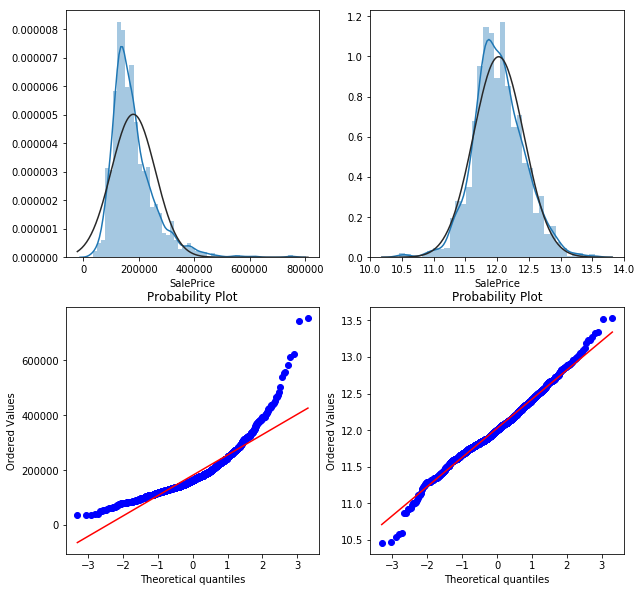

In [38]:
draw2by2log(train_clean['SalePrice'])

<Figure size 432x288 with 0 Axes>

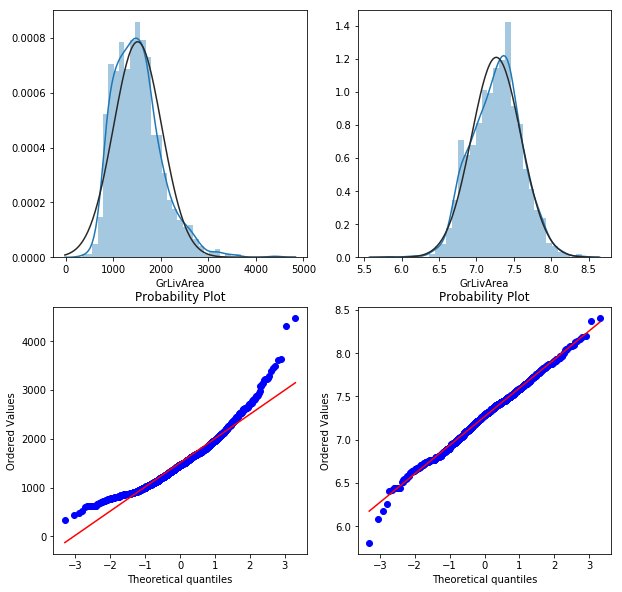

In [39]:
draw2by2log(train_clean['GrLivArea'])

Although it's more "normal" after the log transformation, I didn't get a better result when using it as a feature. I'll still use un-transformed numerical data in data sets.

### Training Data Ready for Tree-based Algorithm

In [40]:
train_clean.head(n=5)

,SalePrice,GrLivArea,MasVnrArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,OverallQual,Fireplaces,GarageCars,has_MasVnrArea,binned_TotalBsmtSF,binned_1stFlrSF,binned_2ndFlrSF,SFcross
0,208500,1710,196.0,856,856,854,7,0,2,1,2,1,4,24
1,181500,1262,0.0,1262,1262,0,6,1,2,0,3,3,1,51
2,223500,1786,162.0,920,920,866,7,1,2,1,2,2,4,29
3,140000,1717,0.0,756,961,756,7,1,3,0,2,2,3,28
4,250000,2198,350.0,1145,1145,1053,8,1,3,1,3,3,5,55


In [41]:
idx_tree = ['SalePrice', 'GrLivArea', 'OverallQual', 'Fireplaces', 'GarageCars', 'has_MasVnrArea', 'SFcross']
train_tree = train_clean[idx_tree]
train_tree.head(n=5)

,SalePrice,GrLivArea,OverallQual,Fireplaces,GarageCars,has_MasVnrArea,SFcross
0,208500,1710,7,0,2,1,24
1,181500,1262,6,1,2,0,51
2,223500,1786,7,1,2,1,29
3,140000,1717,7,1,3,0,28
4,250000,2198,8,1,3,1,55


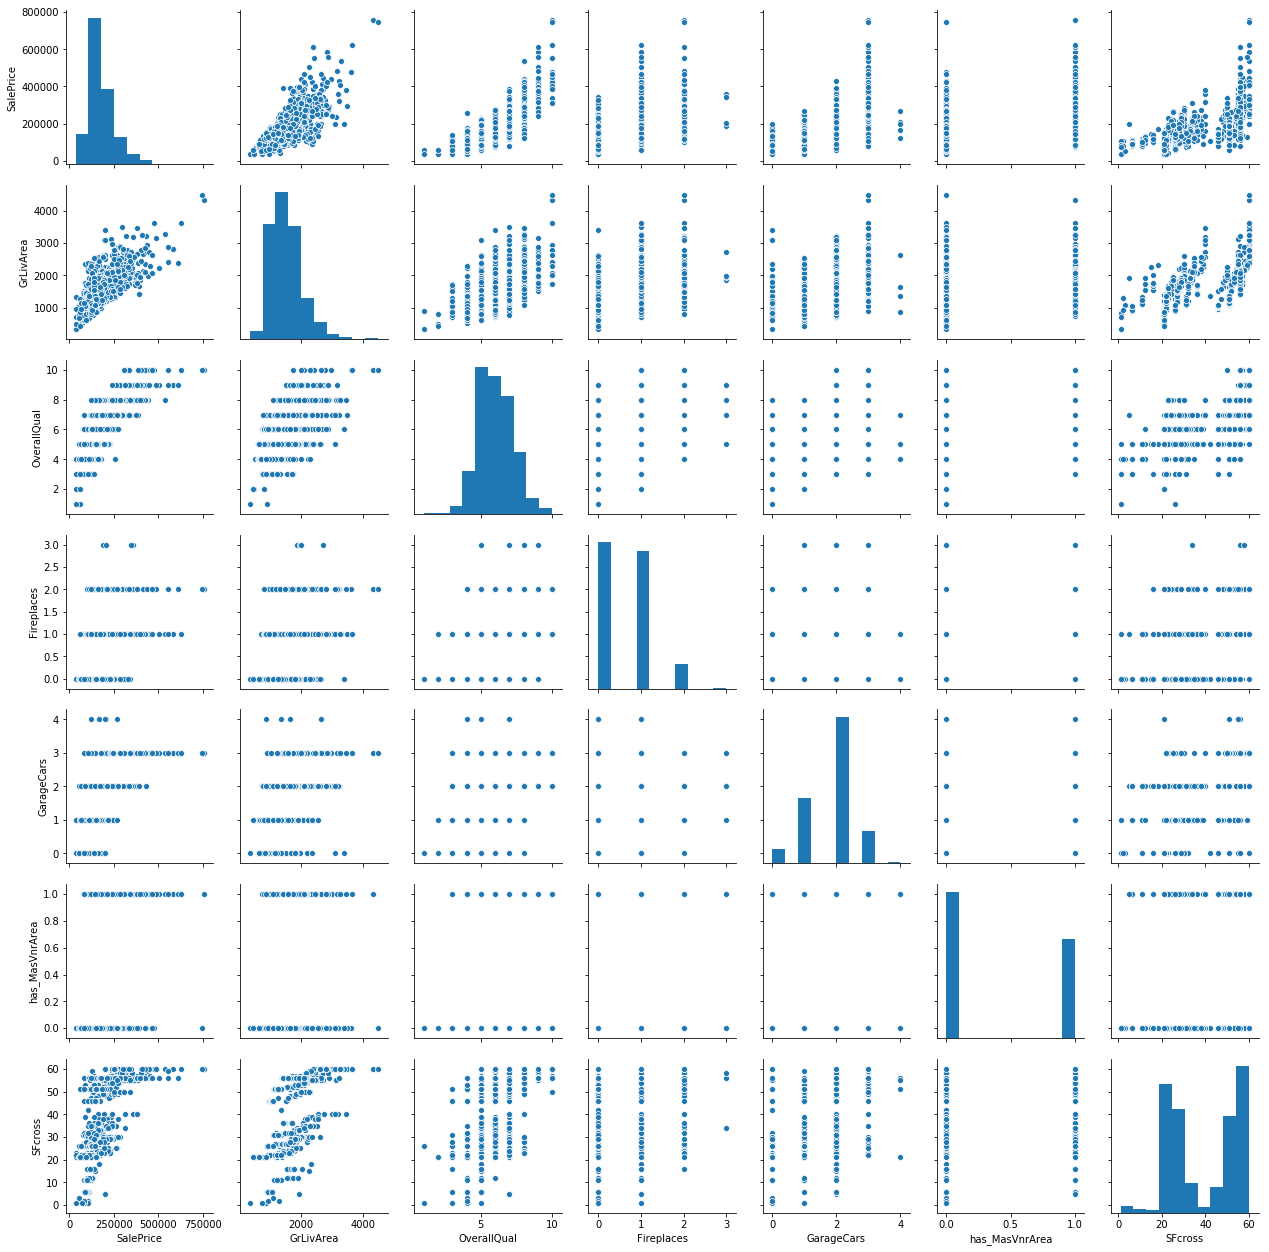

In [42]:
sns.pairplot(train_tree)

- we can compare with the previous pairplot before feature engineering, we have less but more sophisticated features
- then, we also need to construct the training data for distance-based algorithm

### one-hot encoding (dummy variables)

In [43]:
print("Max Fireplaces value in train.csv: %d, in test.csv: %d" % (train_csv['Fireplaces'].max(), final_csv['Fireplaces'].max()) )
print("Min Fireplaces value in train.csv: %d, in test.csv: %d" % (train_csv['Fireplaces'].min(), final_csv['Fireplaces'].min()) )

Max Fireplaces value in train.csv: 3, in test.csv: 4
Min Fireplaces value in train.csv: 0, in test.csv: 0


In [44]:
print("Max GarageCars value in train.csv: %d, in test.csv: %d" % (train_csv['GarageCars'].max(), final_csv['GarageCars'].max()) )
print("Min GarageCars value in train.csv: %d, in test.csv: %d" % (train_csv['GarageCars'].min(), final_csv['GarageCars'].min()) )

Max GarageCars value in train.csv: 4, in test.csv: 5
Min GarageCars value in train.csv: 0, in test.csv: 0


In [45]:
dummy_fields = ['OverallQual', 'Fireplaces', 'GarageCars', 'has_MasVnrArea', 'SFcross']
train_dist = train_tree[['SalePrice', 'OverallQual', 'GrLivArea']].copy()
for field in dummy_fields:
    dummies = pd.get_dummies(train_tree.loc[:, field], prefix=field)
    train_dist = pd.concat([train_dist, dummies], axis = 1)
train_dist['GarageCars_5'] = 0
train_dist['Fireplaces_4'] = 0
train_dist.head(n=5)

,SalePrice,OverallQual,GrLivArea,OverallQual_1,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,...,SFcross_53,SFcross_54,SFcross_55,SFcross_56,SFcross_57,SFcross_58,SFcross_59,SFcross_60,GarageCars_5,Fireplaces_4
0,208500,7,1710,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,181500,6,1262,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,223500,7,1786,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,140000,7,1717,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,250000,8,2198,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [46]:
print("The dimension for the input of distance-based model is %d x %d" % (train_dist.shape[0], train_dist.shape[1] - 1))
# SalePrice is not input, so minus one

The dimension for the input of distance-based model is 1458 x 70
